In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('fulldata.csv')


In [2]:
target = ['Close']
features = ['Transaction','Open', 'High', 'Low','TrustNet']
df = stock_data[features + target]

In [3]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])


In [4]:
# extract the input sequences and output values
sequence_length = 5

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

In [5]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             11400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 72,821
Trainable params: 72,821
Non-traina

In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
32/32 [==============================] - 3s 8ms/step - loss: 0.0158
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 7.6551e-04
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 6.5320e-04
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 6.6473e-04
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 6.3705e-04
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 5.8053e-04
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 6.8726e-04
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 5.3421e-04
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 5.9350e-04
Epoch 11/50
32/32 [==============================] - 0s 7ms/step - loss: 6.3552e-04
Epoch 12/50
32/32 [==============================] - 0s 8ms/step - loss: 5.1405e-04
Epoch 13/

In [11]:
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index()
test

,index,DateTime,Open,Close,Predicted
0,2016,2021-03-31,596.0,587.0,597.150940
1,2017,2021-04-01,598.0,602.0,601.570984
2,2018,2021-04-06,615.0,610.0,605.530884
3,2019,2021-04-07,614.0,610.0,609.951416
4,2020,2021-04-08,606.0,613.0,613.247070
5,2021,2021-04-09,618.0,610.0,617.771729
6,2022,2021-04-12,612.0,605.0,622.474976
7,2023,2021-04-13,604.0,605.0,624.756226
8,2024,2021-04-14,608.0,612.0,624.199707
9,2025,2021-04-15,612.0,619.0,623.120422


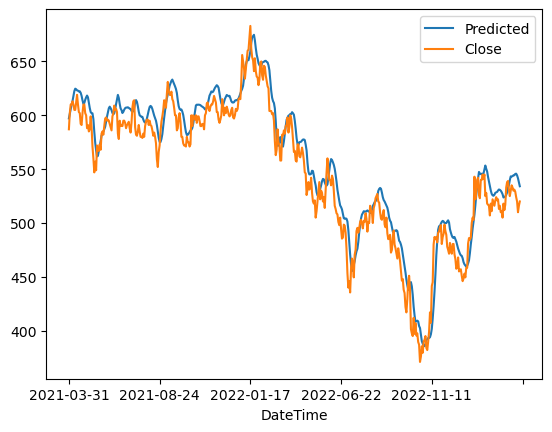

In [9]:
plot=test.plot(x='DateTime',y=['Predicted','Close'])
fig = plot.get_figure()

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

test.loc[test.Close.shift(1) >= test.Close, "Trend"]= 0
test.loc[test.Close.shift(1) < test.Close, "Trend"]= 1
test['Trend']=test['Trend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Predicted, "PredTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Predicted, "PredTrend"]= 1
test['PredTrend']=test['PredTrend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Close.shift(1), "PredvsTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Close.shift(1), "PredvsTrend"]= 1
test['PredvsTrend']=test['PredvsTrend'].fillna(0).astype(int)


test['status2']=test.status
test.loc[( (test.status.shift(1)==0) & (test.status==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 0
test.loc[( (test.status.shift(1)==1) & (test.status==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 1
# test['status2']=test['status2'].fillna(0).astype(int)
# test['status2']=test['status2']

# 做一條predict的均線試看看

test['status_LSTM']= test.PredvsTrend.shift(1).fillna(0).astype(int)
test.loc[( (test.PredvsTrend.shift(1)==0) & (test.PredvsTrend==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 0
test.loc[( (test.PredvsTrend.shift(1)==1) & (test.PredvsTrend==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 1

# 傳統均線操作法

test['fivemean'] = (test.Close.shift(1)+test.Close.shift(2)+test.Close.shift(3)+test.Close.shift(4)+test.Close)/5
test['fivemean']=test['fivemean'].fillna(test.Close)

test.loc[test.Close>=test.fivemean, "fivetoclose"]= 1
test.loc[test.Close<test.fivemean, "fivetoclose"]= 0
test['fivetoclose']=test['fivetoclose'].fillna(0).astype(int)

test['status_tradition'] = test.fivetoclose.shift(1).fillna(0).astype(int)



# 
test['status'] = test.status_LSTM

test['buy_cost'] = test.Open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret 
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

test

,index,DateTime,Open,Close,Predicted,Trend,PredTrend,PredvsTrend,status,status2,status-LSTM,status3,fivemean,fivetoclose,status-tradition,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity,status_LSTM,status_tradition
0,2016,2021-03-31,596.0,587.0,597.150940,0,0,0,0,0,0,0.0,587.0,1,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0,0
1,2017,2021-04-01,598.0,602.0,601.570984,1,1,0,0,1,0,0.0,602.0,1,1,0.0,0.0,0.000000,0.000000,0.003356,0.000000,0.000000,1.003356,1.000000,1.000000,0,1
2,2018,2021-04-06,615.0,610.0,605.530884,1,1,1,0,1,0,0.0,610.0,1,1,0.0,0.0,0.000000,0.000000,0.028428,0.000000,0.000000,1.031879,1.000000,1.000000,0,1
3,2019,2021-04-07,614.0,610.0,609.951416,0,1,1,1,1,1,0.0,610.0,1,1,614.0,0.0,0.000000,0.000000,-0.001626,-0.000000,-0.000000,1.030201,1.000000,1.000000,1,1
4,2020,2021-04-08,606.0,613.0,613.247070,1,1,1,1,1,1,0.0,604.4,1,1,0.0,0.0,0.000000,0.000000,-0.013029,-0.013029,-0.013029,1.016779,0.986971,0.986971,1,1
5,2021,2021-04-09,618.0,610.0,617.771729,0,1,0,1,1,1,0.0,609.0,1,1,0.0,0.0,0.000000,0.000000,0.019802,0.019802,0.019802,1.036913,1.006515,1.006515,1,1
6,2022,2021-04-12,612.0,605.0,622.474976,0,1,0,0,1,0,0.0,609.6,0,1,0.0,612.0,-0.003257,-0.005257,-0.009709,-0.009709,-0.011709,1.026846,0.996743,0.994730,0,1
7,2023,2021-04-13,604.0,605.0,624.756226,0,1,0,0,0,0,0.0,608.6,0,0,0.0,0.0,0.000000,0.000000,-0.013072,-0.000000,-0.000000,1.013423,0.996743,0.994730,0,0
8,2024,2021-04-14,608.0,612.0,624.199707,1,0,0,0,0,0,0.0,609.0,1,0,0.0,0.0,0.000000,0.000000,0.006623,0.000000,0.000000,1.020134,0.996743,0.994730,0,0
9,2025,2021-04-15,612.0,619.0,623.120422,1,0,0,0,1,0,0.0,610.2,1,1,0.0,0.0,0.000000,0.000000,0.006579,0.000000,0.000000,1.026846,0.996743,0.994730,0,1


Text(0, 0.5, 'strategy_equity')

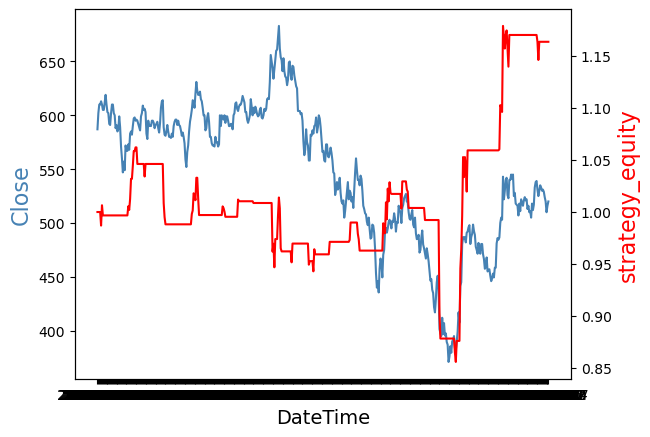

In [22]:
col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_equity, color=col2)
ax2.set_ylabel('strategy_equity', color=col2, fontsize=16)

In [39]:
# 如果train的結果很好再存
# model.save('BEST-2.h5')
# fig2.savefig("BEST-2.png")